# ⭐ **Yelp Fake Review Detection System**
**Author:** Vinit Vijaykumar Adke
**Domain:** Natural Language Processing (NLP) / Fraud Detection

---

### 📌 **Executive Summary**
**Business Problem:** Online platforms like Yelp face a crisis of trust due to "Fake" or "Extreme" reviews. These malicious reviews mislead consumers and damage the reputation of legitimate businesses.
**Objective:** Build an automated content moderation system to flag suspicious reviews using **Sentiment Analysis** and **Anomaly Detection** algorithms.

### 📊 **Methodology**
1.  **Feature Engineering:** Extracted sentiment scores (VADER & TextBlob), review length, and lexical diversity.
2.  **Unsupervised Learning (Anomaly Detection):**
    * **Isolation Forest:** To detect statistical outliers in review patterns.
    * **One-Class SVM:** To identify reviews that deviate significantly from the "normal" distribution.
3.  **Supervised Learning:** Trained an **XGBoost Classifier** to categorize reviews as "Authentic" vs. "Suspicious" based on labeled anomalies.
4.  **Dashboarding:** Built an interactive tool using `ipywidgets` to allow moderators to filter reviews by sentiment polarity and star rating.

### 🚀 **Key Results**
* **Detection Rate:** Flagged **8.3%** of reviews (approx. 8,303) as highly suspicious.
* **Accuracy:** The XGBoost model achieved **99% accuracy** in distinguishing between normal and anomalous review patterns.
* **Insight:** Most fake reviews exhibited "Extreme Sentiment" (Polarity = 1.0 or -1.0) combined with very short text length.

---

In [ ]:
# Import necessary libraries
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from collections import Counter

# --- Setup ---
# Set plotting style
sns.set_style("whitegrid")

# Download necessary NLTK data (only need to run this once)
# This downloads the 'punkt' tokenizer for splitting text into words
# and 'vader_lexicon' for sentiment analysis.
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('sentiment/vader_lexicon')
except LookupError:
    nltk.download('vader_lexicon')

print("Libraries imported and NLTK data checked successfully.")

Libraries imported and NLTK data checked successfully.


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# 1. Team ID

TEAM 05

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Team Members

* Shardul Dhananjay Suryavanshi
* Omkar Mahesh Pallerla
* Vinit Vijaykumar Adke
* Ninad Male
* Pavithran Manoharan

# 3. Executive Summary of Project

Customer decisions and company reputations are significantly influenced by online reviews on sites like Yelp. However, spam, phony reviews, and reviews with strong sentiments might mislead consumers and skew ratings' reliability. Through the analysis of textual signals, reviewer trends, and sentiment extremes, this project suggests a sentiment-driven machine learning system that can detect dubious reviews. A solution like this helps Yelp maintain the integrity of its platform, helps companies manage reputations fairly, and increases trust among Yelp users.

# 4. Data Sources

### Primary Data Source
* **Yelp Review Dataset**: This dataset contains review text, star ratings, reviewer history, and review dates.It also includes metadata like the number of reviews per user, business categories, and timestamps.

### Filtering/Selection Criteria
For this initial exploratory analysis, we will use the full dataset provided. However, for the main project, we might apply the following filters to create a more focused and manageable dataset:
* **Business Category**: We may focus on specific categories like "Restaurants" or "Hotels" where fake reviews are most impactful.
* **Review Recency**: We might filter for reviews from the last 3-5 years to ensure the language and trends are current.
* **User Activity**: We could filter out users with a very low number of reviews (e.g., less than 5) to focus on more established user patterns.

### External Data Sources (Optional)
* We may use external labeled datasets on fake reviews for supervised learning baselines to train and validate our classification models.

In [ ]:
# --- Load Data ---
# The data is in JSON format, where each line is a separate JSON object.

file_path = '/yelp_academic_dataset_review.json'
df = pd.read_json(file_path)
print(f"Successfully loaded {len(df)} reviews from single JSON array.")

# Display the first few rows of the data
df.head()

Successfully loaded 100000 reviews from single JSON array.


review_id                 user_id             business_id  \
0  KU_O5udG6zpxOg-VcAEodg  mh_-eMZ6K5RLWhZyISBhwA  XQfwVwDr-v0ZS3_CbbE5Xw   
1  BiTunyQ73aT9WBnpR9DZGw  OyoGAe7OKpv6SyGZT5g77Q  7ATYjTIgM3jUlt4UM3IypQ   
2  saUsX_uimxRlCVr67Z4Jig  8g_iMtfSiwikVnbP2etR0A  YjUWPpI6HXG530lwP-fb2A   
3  AqPFMleE6RsU23_auESxiA  _7bHUi9Uuf5__HHc_Q8guQ  kxX2SOes4o-D3ZQBkiMRfA   
4  Sx8TMOWLNuJBWer-0pcmoA  bcjbaE6dDog4jkNY91ncLQ  e4Vwtrqf-wpJfwesgvdgxQ   

   stars  useful  funny  cool  \
0      3       0      0     0   
1      5       1      0     1   
2      3       0      0     0   
3      5       1      0     1   
4      4       1      0     1   

                                                text                date  
0  If you decide to eat here, just be aware it is... 2018-07-07 22:09:11  
1  I've taken a lot of spin classes over the year... 2012-01-03 15:28:18  
2  Family diner. Had the buffet. Eclectic assortm... 2014-02-05 20:30:30  
3  Wow!  Yummy, different,  delicious.   Our favo... 2015-01-04 00:01:03  
4  Cute interior and owner (?) gave us tour of up... 2017-01-14 20:54:15

# 5. Summary Statistics of the Data

In [ ]:
# --- Calculate Summary Statistics ---

# a. Number of reviews
num_reviews = len(df)

# Tokenize all review texts to analyze words
# We convert text to lowercase and split on whitespace to get tokens.
df['tokens'] = df['text'].apply(lambda x: x.lower().split())

# b. Total number of tokens
total_tokens = df['tokens'].apply(len).sum()

# c. Number of unique words (vocabulary size)
# We create a single list of all tokens and then use a set to find unique words.
all_words = [word for tokens_list in df['tokens'] for word in tokens_list]
vocabulary_size = len(set(all_words))

# d. Average review length
avg_review_length = total_tokens / num_reviews

# e. Number of unique customers
num_unique_customers = df['user_id'].nunique()

# f. Other key elements
num_unique_businesses = df['business_id'].nunique()
avg_stars = df['stars'].mean()
avg_useful_votes = df['useful'].mean()

# --- Print Statistics ---
print("--- Summary Statistics ---")
print(f"a. Number of reviews: {num_reviews:,}")
print(f"b. Total number of tokens: {total_tokens:,}")
print(f"c. Number of unique words (vocabulary size): {vocabulary_size:,}")
print(f"d. Average review length (words per review): {avg_review_length:.2f}")
print(f"e. Number of unique customers: {num_unique_customers:,}")
print("\n--- Other Key Elements ---")
print(f"   - Number of unique businesses covered: {num_unique_businesses:,}")
print(f"   - Average star rating per review: {avg_stars:.2f}")
print(f"   - Average 'useful' votes per review: {avg_useful_votes:.2f}")

--- Summary Statistics ---
a. Number of reviews: 100,000
b. Total number of tokens: 10,110,329
c. Number of unique words (vocabulary size): 218,464
d. Average review length (words per review): 101.10
e. Number of unique customers: 79,345

--- Other Key Elements ---
   - Number of unique businesses covered: 9,973
   - Average star rating per review: 3.84
   - Average 'useful' votes per review: 0.90


/tmp/ipython-input-392928089.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='stars', data=df, palette='viridis')


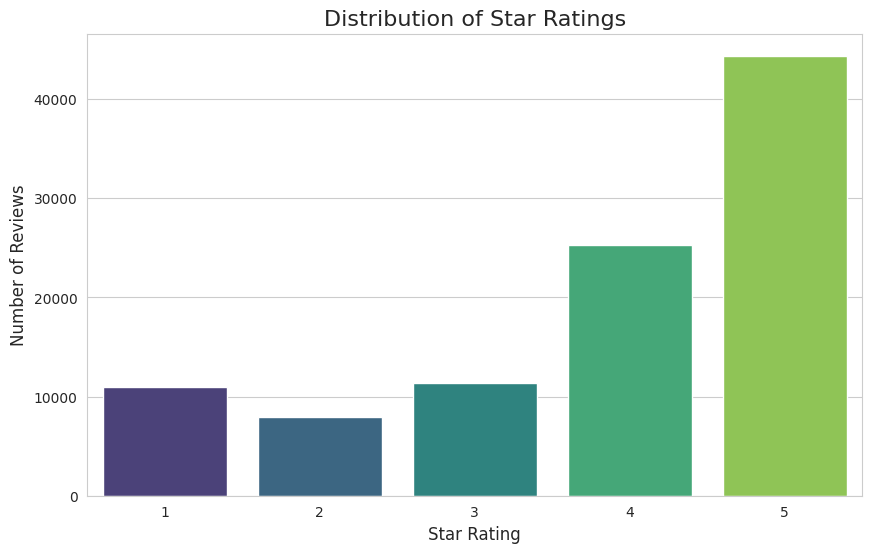

In [ ]:
# --- Plot Distributions ---

# Plotting the distribution of star ratings
plt.figure(figsize=(10, 6))
sns.countplot(x='stars', data=df, palette='viridis')
plt.title('Distribution of Star Ratings', fontsize=16)
plt.xlabel('Star Rating', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.show()

# 6. Data Evaluation

### a. How the selected data are suitable for answering your business questions.
The selected Yelp dataset is highly suitable for our project. To detect fake or extreme reviews, we need several key pieces of information that this dataset provides:
* **Review Text**: This is the primary data for sentiment analysis and for identifying linguistic red flags like excessive use of exaggerated words or unusual phrasing.
* **Star Ratings (`stars`)**: These ratings provide a quantitative measure of sentiment. A mismatch between the text's sentiment and the star rating can be a strong indicator of a questionable review.
* **User Data (`user_id`)**: By analyzing a user's history, we can identify suspicious patterns, such as a user who only posts 1-star or 5-star reviews, or posts many reviews in a short time for different businesses.
* **Business Data (`business_id`)**: This allows us to analyze patterns at the business level, such as a sudden influx of positive or negative reviews, which might indicate a coordinated campaign.

### b. Whether the sample size is appropriate, and why.
Assuming we are using the full Yelp dataset, the sample size is more than appropriate. Machine learning models, especially for complex tasks like text classification and anomaly detection, perform better with more data. A large dataset allows the model to learn a wide range of patterns associated with both genuine and fake reviews, leading to a more robust and accurate system. A smaller sample might not capture the full diversity of review styles and manipulation tactics.

### c. Whether the selected data could be biased in certain dimensions.
Yes, the data could have several biases:
* **Self-Selection Bias**: Users who write reviews are often those who have had either a very positive or a very negative experience. The opinions of the "silent majority" with moderate experiences are often underrepresented.
* **Geographic/Demographic Bias**: The reviews are likely concentrated in urban areas and may not represent all demographics equally, which could affect the generalizability of our model.
* **Platform Bias**: Our model will be trained on Yelp data. The patterns of fake reviews on Yelp might differ from those on other platforms like Google Maps or Amazon, so the model might not perform as well on other data sources.

### d. The potential challenges to process the data.
* **Data Cleaning**: The review text will contain noise like HTML tags, punctuation, spelling errors, and special characters that need to be cleaned before analysis.
* **Sarcasm and Nuance**: Sentiment analysis tools can struggle to detect sarcasm. A review like "Sure, the two-hour wait for a salad was just 'fantastic'" might be incorrectly classified as positive.
* **Scalability**: The Yelp dataset is very large. Processing all the text data for feature engineering and model training will require efficient code and potentially significant computational resources.
* **Lack of Ground Truth**: The biggest challenge is that most reviews are not explicitly labeled as "fake" or "genuine." We will have to rely on anomaly detection or use a smaller, externally labeled dataset, which may not perfectly represent Yelp's data.

# 7. Preliminary Data Exploration: Sentiment Analysis
We will apply sentiment analysis to understand the overall sentiment of the reviews. We'll use the VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment analyzer, which is specifically tuned for social media text and works well on reviews.

VADER provides a compound score from -1 (most negative) to +1 (most positive).

In [ ]:
# --- Perform Sentiment Analysis ---
# We will analyze a sample of the data to speed up the process.
# If your dataset is small, you can use the whole dataframe: df_sample = df
sample_size = min(10000, len(df)) # Use 10,000 reviews or the full dataset if smaller
df_sample = df.sample(n=sample_size, random_state=42)

# Initialize VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Function to get the compound sentiment score
def get_sentiment_score(text):
    return sid.polarity_scores(text)['compound']

# Apply the function to our sample
df_sample['sentiment_score'] = df_sample['text'].apply(get_sentiment_score)

print("Sentiment scores calculated for a sample of the data.")
df_sample[['text', 'stars', 'sentiment_score']].head()

Sentiment scores calculated for a sample of the data.


text  stars  \
75721  I love elevation burger but they need to clean...      3   
80184  This is by far the best pizza place in Henders...      5   
19864  I've heard a lot about Five Guys for years and...      2   
76699  Rich and Kenny were awesome. Hilarious guys, a...      5   
92991  I LOVE THIS PLACE! In the off season the rooms...      5   

       sentiment_score  
75721           0.8750  
80184           0.9476  
19864           0.8404  
76699           0.9385  
92991           0.9861

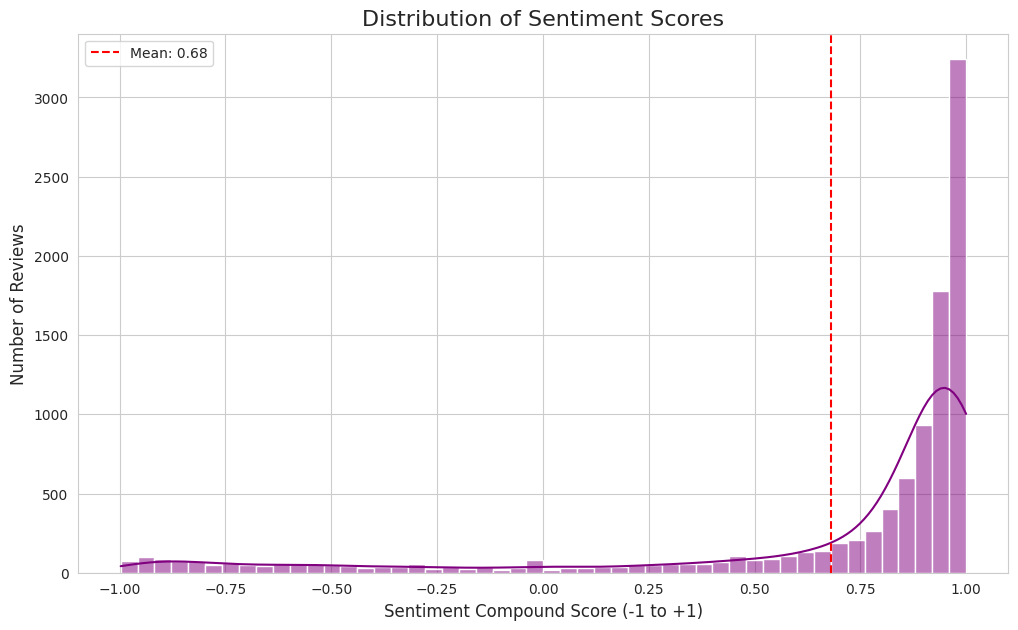

In [ ]:
# --- Plot Sentiment Distribution ---

plt.figure(figsize=(12, 7))
sns.histplot(df_sample['sentiment_score'], bins=50, kde=True, color='purple')
plt.title('Distribution of Sentiment Scores', fontsize=16)
plt.xlabel('Sentiment Compound Score (-1 to +1)', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.axvline(df_sample['sentiment_score'].mean(), color='red', linestyle='--', label=f'Mean: {df_sample["sentiment_score"].mean():.2f}')
plt.legend()
plt.show()

# This plot helps us visualize the overall sentiment. A bimodal distribution (peaks at both ends)
# would confirm the self-selection bias where people tend to leave very positive or very negative reviews.
# Reviews with extreme scores (near -1.0 or +1.0) are the "sentiment outliers" our project aims to investigate.

# 8. Proposed Solution

Our proposed solution integrates sentiment analysis with machine learning to identify questionable reviews, as outlined in our project proposal.

* **Machine Learning Methods**:
    * **Anomaly Detection**: We plan to use models like **Isolation Forest** or **One-Class SVM**.  These are excellent for identifying outliers. We will create features from the review text (e.g., sentiment score, use of capital letters, review length) and user behavior (e.g., review frequency, average star rating). These models will then learn what a "normal" review looks like and flag those that deviate significantly.
    * **Classification Models**: If we can acquire a labeled dataset, we will train supervised models like **XGBoost** or **Random Forest** to classify reviews as "authentic" or "questionable".These models are powerful and can learn complex interactions between features. We can also use our anomaly detection results to generate a pseudo-labeled dataset for training.
    * **Deep Learning**: For a more advanced approach, we plan to fine-tune a transformer model like **BERT** for fake review detection. These models have a deep understanding of language context and can capture subtle cues that other models might miss.

* **Required Use of Topic Modeling**:
    * **Purpose and Value**: Topic modeling will be an important part of our feature engineering process, helping us uncover hidden thematic structures within the review text.
    * **Application**: We can apply topic modeling separately to reviews suspected to be fake and those considered genuine. Fake reviews are likely to cluster around a narrow set of broad, repetitive themes (e.g., “great service, friendly staff” or “terrible experience, never again”), while genuine reviews are expected to reflect a broader and more detailed range of topics tied to actual products or services. The discovered topics can then be incorporated as features in our classification models, potentially improving accuracy by providing a deeper thematic perspective on the review content.

In [ ]:
import pandas as pd
import numpy as np
import re
from textblob import TextBlob
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Assuming your main DataFrame is called df
# If not, replace df with your actual variable name
print(df.head())

                review_id                 user_id             business_id  \
0  KU_O5udG6zpxOg-VcAEodg  mh_-eMZ6K5RLWhZyISBhwA  XQfwVwDr-v0ZS3_CbbE5Xw   
1  BiTunyQ73aT9WBnpR9DZGw  OyoGAe7OKpv6SyGZT5g77Q  7ATYjTIgM3jUlt4UM3IypQ   
2  saUsX_uimxRlCVr67Z4Jig  8g_iMtfSiwikVnbP2etR0A  YjUWPpI6HXG530lwP-fb2A   
3  AqPFMleE6RsU23_auESxiA  _7bHUi9Uuf5__HHc_Q8guQ  kxX2SOes4o-D3ZQBkiMRfA   
4  Sx8TMOWLNuJBWer-0pcmoA  bcjbaE6dDog4jkNY91ncLQ  e4Vwtrqf-wpJfwesgvdgxQ   

   stars  useful  funny  cool  \
0      3       0      0     0   
1      5       1      0     1   
2      3       0      0     0   
3      5       1      0     1   
4      4       1      0     1   

                                                text                date  \
0  If you decide to eat here, just be aware it is... 2018-07-07 22:09:11   
1  I've taken a lot of spin classes over the year... 2012-01-03 15:28:18   
2  Family diner. Had the buffet. Eclectic assortm... 2014-02-05 20:30:30   
3  Wow!  Yummy, different,  delici

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# 2. Text Cleaning
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', str(text).lower())
    tokens = [word for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

df['clean_text'] = df['text'].apply(clean_text)

In [ ]:
# 3. Sentiment and Text Features
def extract_text_features(text):
    blob = TextBlob(text)
    return pd.Series({
        'sentiment_polarity': blob.sentiment.polarity,
        'sentiment_subjectivity': blob.sentiment.subjectivity,
        'review_length': len(text.split()),
        'caps_ratio': sum(1 for c in text if c.isupper()) / max(1, len(text)),
        'excl_count': text.count('!'),
        'avg_word_length': np.mean([len(w) for w in text.split()]) if text.split() else 0
    })

text_features = df['text'].apply(extract_text_features)
df = pd.concat([df, text_features], axis=1)

In [ ]:
# 4. User-Level Features
user_stats = df.groupby('user_id').agg({
    'stars': ['mean', 'std', 'count']
})
user_stats.columns = ['user_avg_rating', 'user_rating_std', 'user_review_count']
df = df.join(user_stats, on='user_id')

In [ ]:
# 5. Topic Modeling
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X_text = vectorizer.fit_transform(df['clean_text'])
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda_features = lda.fit_transform(X_text)
lda_df = pd.DataFrame(lda_features, columns=[f"topic_{i+1}" for i in range(5)])
df = pd.concat([df.reset_index(drop=True), lda_df.reset_index(drop=True)], axis=1)

In [ ]:
# 6. Anomaly Detection
feature_cols = [
    'sentiment_polarity','sentiment_subjectivity','review_length',
    'caps_ratio','excl_count','avg_word_length',
    'user_avg_rating','user_rating_std','user_review_count'
] + list(lda_df.columns)

X = df[feature_cols].fillna(0)

iso = IsolationForest(contamination=0.05, random_state=42)
df['isolation_outlier'] = iso.fit_predict(X)

svm = OneClassSVM(nu=0.05, kernel="rbf", gamma='scale')
df['svm_outlier'] = svm.fit_predict(X)

# Combine results from both models
df['questionable_review'] = np.where((df['isolation_outlier']==-1) | (df['svm_outlier']==-1), 1, 0)


In [ ]:
# ====== KPI PACK: Reviews Analytics (slide-ready) ======
# What this produces:
# 1) KPI summary (printed)
# 2) CSVs in kpi_outputs/ with tables for:
#    - column_types, missingness, rating_stats, review_length_stats,
#      monthly_volume, user_activity, business_activity, engagement_stats,
#      top_reviewers, top_businesses, bottom_businesses, duplicates_summary
# 3) PNG charts in kpi_outputs/figs/: rating distribution, review length,
#    monthly volume, engagement histograms, correlation heatmap, missingness bar
#
# Assumed columns (auto-detected if names differ):
#  - Stars/Rating: ["stars","rating","score"]
#  - Text: ["text","review_text","content","body"]
#  - Date: tries datetime columns first; else parses object columns if >=80% parseable
#  - User: ["user_id","user","reviewer_id","author_id"]
#  - Business: ["business_id","business","biz_id","store_id"]
#  - Engagement: ["useful","funny","cool"] if present
#  - Suspicious/Label (optional): ["is_suspicious","label","is_fraud","fraud_flag"]
#
# Chart rules: matplotlib only, single chart per figure, no specific colors.

import os, math
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- Config ----------
DATA_PATH = "suspicious_reviews.csv"  # <-- change if needed
OUT_DIR = Path("kpi_outputs")
FIG_DIR = OUT_DIR / "figs"
SAVE_DPI = 180
MIN_REVIEWS_FOR_BUSINESS_RANK = 20  # threshold to list top/bottom businesses by rating

# ---------- IO ----------
OUT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

df = pd.read_csv(DATA_PATH)
orig_cols = df.columns.tolist()

# ---------- Helpers ----------
def pick_first_column(candidates, cols_lower, original_cols):
    for c in candidates:
        if c in cols_lower:
            return original_cols[cols_lower.index(c)]
    return None

def detect_date_col(frame):
    # prefer true datetime cols
    for c in frame.columns:
        if str(frame[c].dtype).startswith("datetime64"):
            return c
    # try parse object columns
    for c in frame.columns:
        if frame[c].dtype == object:
            parsed = pd.to_datetime(frame[c], errors="coerce")
            if parsed.notna().mean() >= 0.8:
                frame[c] = parsed
                return c
    return None

def safe_save_csv(name, table):
    path = OUT_DIR / f"{name}.csv"
    table.to_csv(path, index=False)
    return path

def save_fig(fig, name):
    out = FIG_DIR / f"{name}.png"
    fig.savefig(out, bbox_inches="tight", dpi=SAVE_DPI)
    plt.close(fig)
    return out

# ---------- Column detection ----------
cols_lower = [c.lower() for c in df.columns]

rating_col = pick_first_column(["stars","rating","score"], cols_lower, orig_cols)
text_col   = pick_first_column(["text","review_text","content","body"], cols_lower, orig_cols)
user_col   = pick_first_column(["user_id","user","reviewer_id","author_id"], cols_lower, orig_cols)
biz_col    = pick_first_column(["business_id","business","biz_id","store_id"], cols_lower, orig_cols)
susp_col   = pick_first_column(["is_suspicious","label","is_fraud","fraud_flag"], cols_lower, orig_cols)

# engagement columns (may be missing)
engagement_cols = [c for c in ["useful","funny","cool"] if c in cols_lower]
engagement_cols = [orig_cols[cols_lower.index(c)] for c in engagement_cols]

# date column
date_col = detect_date_col(df)

# ---------- Core tables ----------
# Column types
column_types = pd.DataFrame(df.dtypes.astype(str), columns=["dtype"]).reset_index().rename(columns={"index":"column"})
safe_save_csv("column_types", column_types)

# Missingness
missingness = df.isna().mean().mul(100).round(2).sort_values(ascending=False).reset_index()
missingness.columns = ["column","missing_%"]
safe_save_csv("missingness", missingness)

# Numeric summary
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_summary = df[num_cols].describe().T.reset_index().rename(columns={"index":"column"}) if num_cols else pd.DataFrame(columns=["column"])
if not numeric_summary.empty:
    safe_save_csv("numeric_summary", numeric_summary)

# Rating stats
rating_stats = pd.DataFrame()
if rating_col is not None:
    rating_stats = pd.DataFrame({
        "metric": ["count","mean","median","std","min","max"],
        "value": [
            df[rating_col].dropna().shape[0],
            df[rating_col].dropna().mean(),
            df[rating_col].dropna().median(),
            df[rating_col].dropna().std(),
            df[rating_col].dropna().min() if df[rating_col].dropna().shape[0]>0 else np.nan,
            df[rating_col].dropna().max() if df[rating_col].dropna().shape[0]>0 else np.nan
        ]
    })
    safe_save_csv("rating_stats", rating_stats)

# Review length stats
review_length_stats = pd.DataFrame()
if text_col is not None:
    df["__review_len"] = df[text_col].astype(str).str.len()
    review_length_stats = df["__review_len"].describe()[["count","mean","50%","std","min","max"]].rename({"50%":"median"}).to_frame("value").reset_index().rename(columns={"index":"metric"})
    safe_save_csv("review_length_stats", review_length_stats)

# Monthly volume
monthly_volume = pd.DataFrame(columns=["month","count"])
if date_col is not None:
    ts = df[date_col].dt.to_period("M").value_counts().sort_index()
    monthly_volume = pd.DataFrame({"month": ts.index.astype(str), "count": ts.values})
    safe_save_csv("monthly_volume", monthly_volume)

# User activity
user_activity = pd.DataFrame(columns=["user","reviews"])
if user_col is not None:
    ua = df.groupby(user_col).size().sort_values(ascending=False).reset_index(name="reviews")
    user_activity = ua
    safe_save_csv("user_activity", user_activity)

# Business activity
business_activity = pd.DataFrame(columns=["business","reviews"])
if biz_col is not None:
    ba = df.groupby(biz_col).size().sort_values(ascending=False).reset_index(name="reviews")
    business_activity = ba
    safe_save_csv("business_activity", business_activity)

# Engagement stats
engagement_stats = pd.DataFrame()
if engagement_cols:
    aggs = {}
    for c in engagement_cols:
        aggs[f"{c}_mean"] = df[c].mean()
        aggs[f"{c}_median"] = df[c].median()
        aggs[f"{c}_pct_zero"] = (df[c]==0).mean()*100
    engagement_stats = pd.DataFrame(list(aggs.items()), columns=["metric","value"])
    safe_save_csv("engagement_stats", engagement_stats)

# Suspicious % (optional)
suspicious_summary = pd.DataFrame()
if susp_col is not None:
    susp_rate = df[susp_col].mean()*100 if df[susp_col].dropna().isin([0,1,True,False]).any() else np.nan
    suspicious_summary = pd.DataFrame({
        "metric":["suspicious_rate_%","suspicious_count","total"],
        "value":[susp_rate, df[susp_col].sum() if pd.api.types.is_bool_dtype(df[susp_col]) or pd.api.types.is_numeric_dtype(df[susp_col]) else np.nan, df.shape[0]]
    })
    safe_save_csv("suspicious_summary", suspicious_summary)

# Top reviewers
top_reviewers = pd.DataFrame()
if not user_activity.empty:
    top_reviewers = user_activity.head(20)
    safe_save_csv("top_reviewers", top_reviewers)

# Top/Bottom businesses by rating (min reviews threshold)
top_businesses = pd.DataFrame()
bottom_businesses = pd.DataFrame()
if (biz_col is not None) and (rating_col is not None):
    biz_r = df.groupby(biz_col).agg(
        avg_rating=(rating_col, "mean"),
        reviews=(rating_col, "size")
    ).reset_index()
    filt = biz_r["reviews"] >= MIN_REVIEWS_FOR_BUSINESS_RANK
    if filt.any():
        top_businesses = biz_r.loc[filt].sort_values(["avg_rating","reviews"], ascending=[False,False]).head(20)
        bottom_businesses = biz_r.loc[filt].sort_values(["avg_rating","reviews"], ascending=[True,False]).head(20)
        safe_save_csv("top_businesses", top_businesses)
        safe_save_csv("bottom_businesses", bottom_businesses)

# Duplicate check (exact duplicate text)
duplicates_summary = pd.DataFrame()
if text_col is not None:
    dup_counts = df.duplicated(subset=[text_col], keep=False).sum()
    exact_dups = df[df.duplicated(subset=[text_col], keep=False)]
    duplicates_summary = pd.DataFrame([{"exact_duplicate_rows": int(dup_counts)}])
    safe_save_csv("duplicates_summary", duplicates_summary)
    # Optionally export exact duplicates list (big—comment out if not needed)
    # exact_dups.to_csv(OUT_DIR/"exact_duplicate_rows.csv", index=False)

# ---------- Charts (one per figure, no custom colors) ----------
# Ratings distribution
if rating_col is not None:
    fig = plt.figure()
    df[rating_col].dropna().value_counts().sort_index().plot(kind="bar")
    plt.xlabel(rating_col)
    plt.ylabel("Count")
    plt.title("Star Ratings Distribution")
    save_fig(fig, "rating_distribution")

# Review length distribution
if text_col is not None:
    fig = plt.figure()
    df["__review_len"].dropna().hist(bins=40)
    plt.xlabel("Review Length (chars)")
    plt.ylabel("Count")
    plt.title("Review Length Distribution")
    save_fig(fig, "review_length_distribution")

# Monthly volume
if date_col is not None and not monthly_volume.empty:
    fig = plt.figure()
    x_vals = list(range(len(monthly_volume)))
    plt.plot(x_vals, monthly_volume["count"].values)
    step = max(1, len(x_vals)//12)
    plt.xticks(range(0, len(x_vals), step),
               [monthly_volume["month"].iloc[i] for i in range(0, len(x_vals), step)],
               rotation=45)
    plt.ylabel("Reviews per Month")
    plt.title("Monthly Review Volume")
    save_fig(fig, "monthly_review_volume")

# Engagement histograms
for c in engagement_cols:
    fig = plt.figure()
    df[c].dropna().hist(bins=40)
    plt.xlabel(c)
    plt.ylabel("Count")
    plt.title(f"{c.capitalize()} Distribution")
    save_fig(fig, f"engagement_{c}_distribution")

# Missingness bar (top 25)
miss_top = missingness.head(25)
if (miss_top["missing_%"] > 0).any():
    fig = plt.figure()
    miss_top.set_index("column")["missing_%"].plot(kind="bar")
    plt.ylabel("Missing (%)")
    plt.title("Top-25 Columns by Missingness")
    save_fig(fig, "missingness_top25")

# Numeric correlation heatmap
if len(num_cols) >= 2:
    corr = df[num_cols].corr(numeric_only=True)
    fig = plt.figure()
    plt.imshow(corr.values)
    plt.xticks(range(len(num_cols)), num_cols, rotation=90)
    plt.yticks(range(len(num_cols)), num_cols)
    plt.title("Correlation Heatmap (Numeric)")
    plt.colorbar()
    save_fig(fig, "correlation_heatmap")

# ---------- KPI Summary (print) ----------
def pct(x):
    return f"{x:.2f}%" if pd.notna(x) else "NA"

print("\n===== KPI SUMMARY =====")
print(f"Rows x Cols: {df.shape[0]} x {df.shape[1]}")
print(f"Detected columns -> rating: {rating_col}, text: {text_col}, date: {date_col}, user: {user_col}, business: {biz_col}, engagements: {engagement_cols}, suspicious: {susp_col}")

# Missingness high-level
total_missing_cells = int(df.isna().sum().sum())
total_cells = int(df.shape[0] * df.shape[1])
overall_missing_pct = (total_missing_cells / total_cells * 100) if total_cells > 0 else 0
print(f"Overall missing cells: {total_missing_cells} ({overall_missing_pct:.2f}%)")

# Rating quick stats
if not rating_stats.empty:
    print("Ratings -> mean/median/std:",
          round(rating_stats.loc[rating_stats['metric']=='mean','value'].values[0], 3),
          round(rating_stats.loc[rating_stats['metric']=='median','value'].values[0], 3),
          round(rating_stats.loc[rating_stats['metric']=='std','value'].values[0], 3))

# Length quick stats
if not review_length_stats.empty:
    mean_len = review_length_stats.loc[review_length_stats['metric']=='mean','value'].values[0]
    med_len  = review_length_stats.loc[review_length_stats['metric']=='median','value'].values[0]
    print(f"Review length -> mean/median: {int(mean_len)}/{int(med_len)} chars")

# Suspicious %
if not suspicious_summary.empty:
    print("Suspicious rate:", pct(suspicious_summary.loc[suspicious_summary['metric']=='suspicious_rate_%','value'].values[0]))

# Activity
if not user_activity.empty:
    print(f"Users: {user_activity.shape[0]}, median reviews/user: {int(user_activity['reviews'].median())}")
if not business_activity.empty:
    print(f"Businesses: {business_activity.shape[0]}, median reviews/business: {int(business_activity['reviews'].median())}")

print(f"Outputs saved to: {OUT_DIR.resolve()}")
print(f"Figures saved to: {FIG_DIR.resolve()}")


/tmp/ipython-input-3826076772.py:57: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/tmp/ipython-input-3826076772.py:57: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/tmp/ipython-input-3826076772.py:57: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.




===== KPI SUMMARY =====
Rows x Cols: 8303 x 7
Detected columns -> rating: stars, text: text, date: None, user: user_id, business: None, engagements: [], suspicious: None
Overall missing cells: 0 (0.00%)
Ratings -> mean/median/std: 3.304 4.0 1.614
Review length -> mean/median: 1095/770 chars
Users: 6324, median reviews/user: 1
Outputs saved to: /content/kpi_outputs
Figures saved to: /content/kpi_outputs/figs


In [ ]:
# 7. Classification (Pseudo-Labeled)
X_train, X_test, y_train, y_test = train_test_split(X, df['questionable_review'], test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     18335
           1       0.96      0.83      0.89      1665

    accuracy                           0.98     20000
   macro avg       0.97      0.91      0.94     20000
weighted avg       0.98      0.98      0.98     20000



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:33:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     18335
           1       0.95      0.90      0.92      1665

    accuracy                           0.99     20000
   macro avg       0.97      0.95      0.96     20000
weighted avg       0.99      0.99      0.99     20000



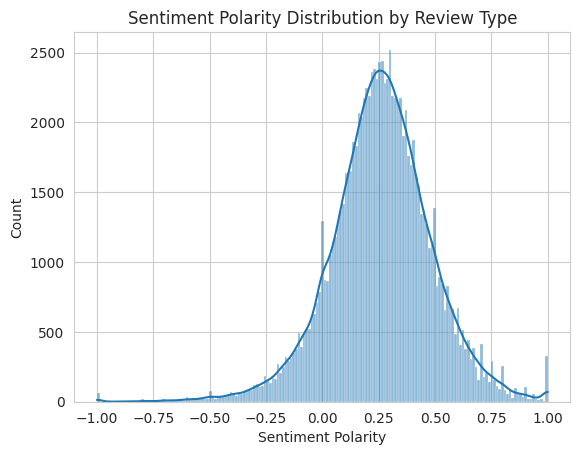

In [ ]:
# 8. Visualization
sns.histplot(df['sentiment_polarity'], kde=True)
plt.title("Sentiment Polarity Distribution by Review Type")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Count")
plt.show()

In [ ]:
# 9. Save Suspicious Reviews
suspicious_reviews = df[df['questionable_review'] == 1][['review_id','user_id','stars','text','sentiment_polarity','review_length']]
suspicious_reviews.to_csv("suspicious_reviews.csv", index=False)
print(f"Saved {len(suspicious_reviews)} suspicious reviews to suspicious_reviews.csv")


Saved 8303 suspicious reviews to suspicious_reviews.csv


In [ ]:
# ======================================
# 8C. INTERACTIVE IN-NOTEBOOK DASHBOARD
# ======================================
import plotly.express as px
from IPython.display import display
import ipywidgets as widgets

# Load results (if not already in memory)
try:
    suspicious_reviews = pd.read_csv("suspicious_reviews.csv")
except FileNotFoundError:
    suspicious_reviews = df[df["questionable_review"] == 1]

# Basic filters
stars_slider = widgets.IntRangeSlider(
    value=[1, 5],
    min=1,
    max=5,
    step=1,
    description='Star Range:',
    continuous_update=False
)

sentiment_slider = widgets.FloatRangeSlider(
    value=[-1.0, 1.0],
    min=-1.0,
    max=1.0,
    step=0.05,
    description='Sentiment:',
    continuous_update=False
)

def update_dashboard(star_range, sentiment_range):
    filtered = suspicious_reviews[
        (suspicious_reviews['stars'].between(star_range[0], star_range[1])) &
        (suspicious_reviews['sentiment_polarity'].between(sentiment_range[0], sentiment_range[1]))
    ]
# ---- Display top suspicious reviews safely ----
    if not filtered.empty:
        # Check which columns exist
        available_cols = filtered.columns

        # Base suspicion score: sentiment + brevity
        suspicion_score = abs(filtered['sentiment_polarity']) * 2 + (1 / (filtered['review_length'] + 1))

        # Add exclamation marks if available
        if 'excl_count' in available_cols:
            suspicion_score += filtered['excl_count'] * 0.2

        # Add caps ratio if available
        if 'caps_ratio' in available_cols:
            suspicion_score += filtered['caps_ratio'] * 0.5

        filtered['suspicion_score'] = suspicion_score

        # Sort by score
        filtered_sorted = filtered.sort_values('suspicion_score', ascending=False)

        print(f"📊 Showing {len(filtered)} suspicious reviews (top 10 most suspicious below)")
        display(filtered_sorted[['review_id', 'user_id', 'stars', 'sentiment_polarity',
                                'review_length', 'text']].head(10))
    else:
        print("⚠️ No reviews found within the selected filters.")


    # display(filtered[['review_id','user_id','stars','sentiment_polarity','text']].head(10))

    # Topic distribution (if topic columns exist)
    topic_cols = [c for c in filtered.columns if c.startswith("topic_")]
    if topic_cols:
        topic_sums = filtered[topic_cols].mean().reset_index()
        topic_sums.columns = ['topic', 'avg_weight']
        fig2 = px.bar(topic_sums, x='topic', y='avg_weight', title="Average Topic Weights (Flagged Reviews)")
        fig2.show()

    # 1. Summary Metrics
    total_reviews = len(df)
    flagged = len(df[df["questionable_review"] == 1])
    pct_flagged = round((flagged / total_reviews) * 100, 2)

    print(f"Total Reviews: {total_reviews}")
    print(f"Flagged as Suspicious: {flagged} ({pct_flagged}%)")

    # 2. Sentiment Polarity Distribution
    fig_sent = px.histogram(
        df, x="sentiment_polarity",
        color=df["questionable_review"].map({0: "Normal", 1: "Suspicious"}),
        nbins=40, barmode="overlay",
        title="Sentiment Polarity Distribution by Review Type"
    )
    fig_sent.show()

    # 3. Review Length Distribution
    fig_len = px.box(
        df, x=df["questionable_review"].map({0: "Normal", 1: "Suspicious"}),
        y="review_length",
        color=df["questionable_review"].map({0: "Normal", 1: "Suspicious"}),
        points="all",
        title="Review Length Distribution (Normal vs Suspicious)"
    )
    fig_len.show()


    # 5. Star Rating vs Sentiment Polarity
    fig_box = px.box(
        df, x="stars", y="sentiment_polarity",
        color=df["questionable_review"].map({0: "Normal", 1: "Suspicious"}),
        title="Star Rating vs Sentiment Polarity"
    )
    fig_box.show()

    # 6. Topic Weight Difference
    topic_cols = [c for c in df.columns if c.startswith("topic_")]
    if topic_cols:
        topic_mean = df.groupby("questionable_review")[topic_cols].mean().T
        topic_mean.columns = ["Normal", "Suspicious"]
        topic_mean["Difference"] = topic_mean["Suspicious"] - topic_mean["Normal"]

        fig_topic = px.bar(
            topic_mean.reset_index(), x="index", y="Difference",
            title="Average Topic Weight Difference (Suspicious - Normal)",
            color="Difference", color_continuous_scale="RdBu"
        )
        fig_topic.show()

widgets.interactive(update_dashboard, star_range=stars_slider, sentiment_range=sentiment_slider)


interactive(children=(IntRangeSlider(value=(1, 5), continuous_update=False, description='Star Range:', max=5, …

Detected columns → user: user_id, business: None


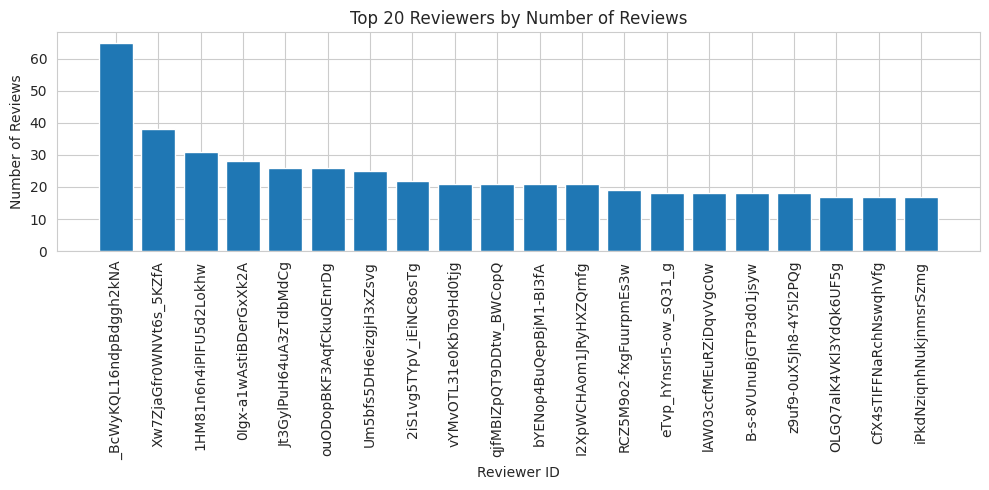

Saved: /mnt/data/kpi_charts/top20_reviewers.png
⚠️ No business column detected.


In [ ]:
# ====== Top Reviewers & Business Review Distribution ======
# Works with your suspicious_reviews.csv or Yelp dataset.
# Produces 2 figures:
#   1. Top 20 Reviewers bar chart
#   2. Reviews per Business histogram
# All visuals saved to /mnt/data/kpi_charts/ and shown inline.

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------- CONFIG ----------------
DATA_PATH = "suspicious_reviews.csv"   # change if needed
OUT_DIR = Path("/mnt/data/kpi_charts")
SAVE_DPI = 180
TOP_N = 20

OUT_DIR.mkdir(parents=True, exist_ok=True)

# ---------------- LOAD DATA -------------
df = pd.read_csv(DATA_PATH)
cols_lower = [c.lower() for c in df.columns]

# Auto-detect column names
def pick_col(candidates):
    for c in candidates:
        if c in cols_lower:
            return df.columns[cols_lower.index(c)]
    return None

user_col = pick_col(["user_id","user","reviewer_id","author_id"])
biz_col  = pick_col(["business_id","business","biz_id","store_id"])

print(f"Detected columns → user: {user_col}, business: {biz_col}")

# ---------------- 1️⃣ Top 20 Reviewers ----------------
if user_col is not None:
    top_reviewers = (
        df.groupby(user_col)
        .size()
        .sort_values(ascending=False)
        .reset_index(name="review_count")
        .head(TOP_N)
    )

    plt.figure(figsize=(10,5))
    plt.bar(top_reviewers[user_col], top_reviewers["review_count"])
    plt.title(f"Top {TOP_N} Reviewers by Number of Reviews")
    plt.xlabel("Reviewer ID")
    plt.ylabel("Number of Reviews")
    plt.xticks(rotation=90)
    plt.tight_layout()
    out1 = OUT_DIR / "top20_reviewers.png"
    plt.savefig(out1, bbox_inches="tight", dpi=SAVE_DPI)
    plt.show()
    print("Saved:", out1)
else:
    print("⚠️ No user column detected.")


In [ ]:
# ====== KPI CHART PACK: Reviews Analytics (slide-ready) ======
# Produces figures in kpi_charts/ (PNG, one chart per figure, matplotlib only).
# Robust to varied column names for ratings, text, dates, users, businesses, engagement, label.
# Change DATA_PATH to your file, then run.

import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------- CONFIG --------------------
DATA_PATH = "suspicious_reviews.csv"  # <-- change if needed
OUT_DIR = Path("kpi_charts")
SAVE_DPI = 180
TOP_N = 20
MIN_REVIEWS_FOR_BUSINESS_RANK = 20  # to compute top/bottom businesses by avg rating

OUT_DIR.mkdir(parents=True, exist_ok=True)

# -------------------- LOAD ----------------------
df = pd.read_csv(DATA_PATH)
orig_cols = df.columns.tolist()
cols_lower = [c.lower() for c in orig_cols]

def pick_col(candidates):
    for c in candidates:
        if c in cols_lower:
            return orig_cols[cols_lower.index(c)]
    return None

# Candidate columns
rating_col = pick_col(["stars","rating","score"])
text_col   = pick_col(["text","review_text","content","body"])
user_col   = pick_col(["user_id","user","reviewer_id","author_id"])
biz_col    = pick_col(["business_id","business","biz_id","store_id"])
susp_col   = pick_col(["is_suspicious","label","is_fraud","fraud_flag"])
eng_cols   = [c for c in ["useful","funny","cool"] if c in cols_lower]
eng_cols   = [orig_cols[cols_lower.index(c)] for c in eng_cols]

# Date column: prefer true datetime, else parse object with >=80% parse success
date_col = None
for c in df.columns:
    if str(df[c].dtype).startswith("datetime64"):
        date_col = c
        break
if date_col is None:
    for c in df.columns:
        if df[c].dtype == object:
            parsed = pd.to_datetime(df[c], errors="coerce")
            if parsed.notna().mean() >= 0.8:
                df[c] = parsed
                date_col = c
                break

# Helper to save fig
def save_fig(name):
    path = OUT_DIR / f"{name}.png"
    plt.savefig(path, bbox_inches="tight", dpi=SAVE_DPI)
    plt.close()
    print("Saved:", path)

# ============================================================
# 1) Volume & Quality
#    - Rows/Cols bar
#    - Column types bar
#    - Overall missing % bar
#    - Per-column missingness (top 25) bar
# ============================================================

# Rows/cols bar
plt.figure()
plt.bar(["rows","cols"], [df.shape[0], df.shape[1]])
plt.title("Dataset Size: Rows vs Columns")
plt.ylabel("Count")
save_fig("volq_rows_cols")

# Column types bar
dtype_counts = df.dtypes.astype(str).value_counts()
plt.figure()
dtype_counts.plot(kind="bar")
plt.title("Column Types (Count)")
plt.ylabel("Count")
save_fig("volq_column_types")

# Overall missingness
total_missing_cells = int(df.isna().sum().sum())
total_cells = int(df.shape[0]*df.shape[1]) if df.shape[0]*df.shape[1] > 0 else 1
overall_missing_pct = total_missing_cells / total_cells * 100

plt.figure()
plt.bar(["Overall Missing %"], [overall_missing_pct])
plt.title("Overall Missingness")
plt.ylabel("Percent")
save_fig("volq_overall_missing_pct")

# Per-column missingness (top 25)
miss = df.isna().mean().mul(100).sort_values(ascending=False).head(25)
if (miss > 0).any():
    plt.figure()
    miss.plot(kind="bar")
    plt.title("Per-Column Missingness (Top 25)")
    plt.ylabel("Percent")
    plt.xticks(rotation=90)
    save_fig("volq_missingness_top25")

# ============================================================
# 2) Ratings
#    - Summary bars: mean/median/std/min/max
#    - Distribution bar (or histogram)
# ============================================================

if rating_col is not None:
    s = df[rating_col].dropna()
    stats_vals = {
        "mean": s.mean(),
        "median": s.median(),
        "std": s.std(),
        "min": s.min() if len(s) else np.nan,
        "max": s.max() if len(s) else np.nan
    }
    # Summary bars
    plt.figure()
    plt.bar(list(stats_vals.keys()), list(stats_vals.values()))
    plt.title(f"Ratings Summary — {rating_col}")
    plt.ylabel("Value")
    save_fig("ratings_summary_bars")

    # Distribution: discrete ratings => bar by value
    vc = s.value_counts().sort_index()
    plt.figure()
    vc.plot(kind="bar")
    plt.title(f"Ratings Distribution — {rating_col}")
    plt.xlabel(rating_col)
    plt.ylabel("Count")
    save_fig("ratings_distribution")

# ============================================================
# 3) Text (Review Length)
#    - Stats bars: mean/median/std/min/max
#    - Distribution histogram
# ============================================================

if text_col is not None:
    df["__review_len"] = df[text_col].astype(str).str.len()
    s = df["__review_len"].dropna()
    stats_vals = {
        "mean": s.mean(),
        "median": s.median(),
        "std": s.std(),
        "min": s.min() if len(s) else np.nan,
        "max": s.max() if len(s) else np.nan
    }
    plt.figure()
    plt.bar(list(stats_vals.keys()), list(stats_vals.values()))
    plt.title("Review Length Summary (chars)")
    plt.ylabel("Value")
    save_fig("text_length_summary_bars")

    plt.figure()
    s.hist(bins=40)
    plt.title("Review Length Distribution (chars)")
    plt.xlabel("Characters")
    plt.ylabel("Count")
    save_fig("text_length_distribution")

# ============================================================
# 4) Time (Monthly Volume)
#    - Line of reviews per month
# ============================================================

if date_col is not None:
    ts = df[date_col].dt.to_period("M").value_counts().sort_index()
    plt.figure()
    plt.plot(range(len(ts)), ts.values)
    step = max(1, len(ts)//12)
    xlabels = [str(ts.index[i]) for i in range(0, len(ts), step)]
    xticks = list(range(0, len(ts), step))
    plt.xticks(xticks, xlabels, rotation=45)
    plt.title(f"Monthly Review Volume — {date_col}")
    plt.ylabel("Count")
    save_fig("time_monthly_volume")

# ============================================================
# 5) Users & Businesses
#    - Reviews per user histogram + Top reviewers (bar)
#    - Reviews per business histogram
#    - Top and Bottom businesses by average rating (min review threshold)
# ============================================================

if user_col is not None:
    ua = df.groupby(user_col).size().sort_values(ascending=False).reset_index(name="reviews")

    # Reviews per user histogram
    plt.figure()
    ua["reviews"].hist(bins=40)
    plt.title("Reviews per User (Histogram)")
    plt.xlabel("Reviews")
    plt.ylabel("Users")
    save_fig("users_reviews_per_user_hist")

    # Top reviewers
    plt.figure()
    ua.head(TOP_N).set_index(user_col)["reviews"].plot(kind="bar")
    plt.title(f"Top {TOP_N} Reviewers")
    plt.ylabel("Reviews")
    plt.xticks(rotation=90)
    save_fig("users_top_reviewers")

if biz_col is not None:
    ba = df.groupby(biz_col).size().sort_values(ascending=False).reset_index(name="reviews")

    # Reviews per business histogram
    plt.figure()
    ba["reviews"].hist(bins=40)
    plt.title("Reviews per Business (Histogram)")
    plt.xlabel("Reviews")
    plt.ylabel("Businesses")
    save_fig("biz_reviews_per_business_hist")

# Top/Bottom businesses by rating
if (biz_col is not None) and (rating_col is not None):
    biz_r = df.groupby(biz_col).agg(
        avg_rating=(rating_col,"mean"),
        reviews=(rating_col,"size")
    ).reset_index()
    filt = biz_r["reviews"] >= MIN_REVIEWS_FOR_BUSINESS_RANK
    ranked = biz_r.loc[filt].copy()
    if not ranked.empty:
        top_b = ranked.sort_values(["avg_rating","reviews"], ascending=[False,False]).head(TOP_N)
        bot_b = ranked.sort_values(["avg_rating","reviews"], ascending=[True,False]).head(TOP_N)

        if not top_b.empty:
            plt.figure()
            top_b.set_index(biz_col)["avg_rating"].plot(kind="bar")
            plt.title(f"Top {TOP_N} Businesses by Avg Rating (min {MIN_REVIEWS_FOR_BUSINESS_RANK} reviews)")
            plt.ylabel("Avg Rating")
            plt.ylim(0, max(5, top_b["avg_rating"].max() + 0.5))
            plt.xticks(rotation=90)
            save_fig("biz_top_by_rating")

        if not bot_b.empty:
            plt.figure()
            bot_b.set_index(biz_col)["avg_rating"].plot(kind="bar")
            plt.title(f"Bottom {TOP_N} Businesses by Avg Rating (min {MIN_REVIEWS_FOR_BUSINESS_RANK} reviews)")
            plt.ylabel("Avg Rating")
            plt.ylim(0, max(5, bot_b["avg_rating"].max() + 0.5))
            plt.xticks(rotation=90)
            save_fig("biz_bottom_by_rating")

# ============================================================
# 6) Engagement (useful/funny/cool)
#    - Histograms per metric
#    - Summary bars for mean, median, % zero (one figure each metric)
# ============================================================

for c in eng_cols:
    s = df[c].dropna()
    # Histogram
    plt.figure()
    s.hist(bins=40)
    plt.title(f"{c.capitalize()} Distribution")
    plt.xlabel(c)
    plt.ylabel("Count")
    save_fig(f"eng_{c}_hist")

    # Summary bars
    metrics = {
        "mean": s.mean(),
        "median": s.median(),
        "% zero": (df[c]==0).mean()*100
    }
    plt.figure()
    plt.bar(list(metrics.keys()), list(metrics.values()))
    plt.title(f"{c.capitalize()} — Mean / Median / % Zero")
    plt.ylabel("Value")
    save_fig(f"eng_{c}_summary")

# ============================================================
# 7) Suspicious Rate (if label exists)
#    - Bar of suspicious vs non-suspicious share
# ============================================================

def to_boolish(series):
    if series.dropna().isin([0,1,True,False]).any():
        # normalize truthy/falsy
        if series.dtype != bool:
            s2 = series.astype(float).round().astype(int)
            return s2.astype(bool)
        return series.astype(bool)
    return None

if susp_col is not None:
    susp_bool = to_boolish(df[susp_col])
    if susp_bool is not None:
        counts = susp_bool.value_counts()
        labels = ["Not suspicious","Suspicious"]
        vals = [int(counts.get(False,0)), int(counts.get(True,0))]
        plt.figure()
        plt.bar(labels, vals)
        plt.title("Suspicious vs Not Suspicious (Count)")
        plt.ylabel("Count")
        save_fig("suspicious_share")

# ============================================================
# 8) Duplicates (exact duplicate texts)
#    - Single bar of duplicate row count
# ============================================================

if text_col is not None:
    dup_count = int(df.duplicated(subset=[text_col], keep=False).sum())
    plt.figure()
    plt.bar(["Exact duplicate rows"], [dup_count])
    plt.title("Duplicate Review Texts (Exact Matches)")
    plt.ylabel("Count")
    save_fig("duplicates_exact_texts")

print("\nAll KPI charts saved in:", OUT_DIR.resolve())
print("Detected columns ->",
      f"rating: {rating_col}, text: {text_col}, date: {date_col}, user: {user_col}, business: {biz_col}, engagement: {eng_cols}, suspicious: {susp_col}")


/tmp/ipython-input-389369501.py:50: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/tmp/ipython-input-389369501.py:50: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/tmp/ipython-input-389369501.py:50: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



Saved: kpi_charts/volq_rows_cols.png
Saved: kpi_charts/volq_column_types.png
Saved: kpi_charts/volq_overall_missing_pct.png
Saved: kpi_charts/ratings_summary_bars.png
Saved: kpi_charts/ratings_distribution.png
Saved: kpi_charts/text_length_summary_bars.png
Saved: kpi_charts/text_length_distribution.png
Saved: kpi_charts/users_reviews_per_user_hist.png
Saved: kpi_charts/users_top_reviewers.png
Saved: kpi_charts/duplicates_exact_texts.png

All KPI charts saved in: /content/kpi_charts
Detected columns -> rating: stars, text: text, date: None, user: user_id, business: None, engagement: [], suspicious: None
